## AuxTel test LTS-337-015 (Small Slew and Settle)

In this notebook, we check the speed and accuracy of the slew and settle of the telescope with a
change of 10 degrees.  Desired specs:

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The pointing accuracy requirement for small slews is:    | 2.5       | Arcsec RMS   |Aux_Tel_Sm_Slew_Abs_Pointing|
The small elevation slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement| 10| Degrees |Aux_Tel_Sm_Elev_Slew|
|The small azimuth slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement.  |10       | Degrees     |Aux_Tel_Sm_Az_Slew|
|The allotted time to perform a slew and settle by Aux_Tel_Sm_Elev_Slew and Aux_Tel_Sm_Az_Slew by the Auxiliary Telescope and meet the Aux_Tel_Sm_Slew_Abs_Pointing pointing requirement.      | 10|Seconds|Aux_Tel_Smslew_AcqTime|

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lsst.ts import salobj
from lsst.ts.observatory.control.auxtel.atcs import ATCS
from lsst.ts.observatory.control.auxtel.latiss import LATISS
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u
from lsst_efd_client import EfdClient


Bad key "text.kerning_factor" on line 4 in
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Set Cerro Pachon location
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [3]:
# for tab completion to work in current notebook instance
%config IPCompleter.use_jedi = False

In [4]:
import logging
stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [5]:
# Get EFD client and bring in Lupton's unpacking code
client = EfdClient('summit_efd')

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

Starting new HTTPS connection (1): roundtable.lsst.codes:443
https://roundtable.lsst.codes:443 "GET /segwarides/ HTTP/1.1" 200 253
Starting new HTTPS connection (1): roundtable.lsst.codes:443
https://roundtable.lsst.codes:443 "GET /segwarides/creds/summit_efd HTTP/1.1" 200 92


In [6]:
#get classes and start them
domain = salobj.Domain()
await asyncio.sleep(10) # This can be removed in the future...
atcs = ATCS(domain)
latiss = LATISS(domain)
await asyncio.gather(atcs.start_task, latiss.start_task)

atmcs: Adding all resources.
atptg: Adding all resources.
ataos: Adding all resources.
atpneumatics: Adding all resources.
athexapod: Adding all resources.
atdome: Adding all resources.
atdometrajectory: Adding all resources.
atcamera: Adding all resources.
atspectrograph: Adding all resources.
atheaderservice: Adding all resources.
atarchiver: Adding all resources.
Read historical data in 0.23 sec
Read 1 history items for RemoteEvent(ATArchiver, 0, authList)
Read 1 history items for RemoteEvent(ATArchiver, 0, errorCode)
Read 100 history items for RemoteEvent(ATArchiver, 0, heartbeat)
Read 42 history items for RemoteEvent(ATArchiver, 0, imageInOODS)
Read 42 history items for RemoteEvent(ATArchiver, 0, imageRetrievalForArchiving)
Read 1 history items for RemoteEvent(ATArchiver, 0, logLevel)
Read 1 history items for RemoteEvent(ATArchiver, 0, logMessage)
Read 1 history items for RemoteEvent(ATArchiver, 0, simulationMode)
Read 1 history items for RemoteEvent(ATArchiver, 0, softwareVersion

[[None, None, None, None, None, None, None], [None, None, None, None]]

In [ ]:
# enable components if required
await atcs.enable()
await latiss.enable()

In [ ]:
# take event checking out the slew commands to test telescope only
# otherwise it'll wait for the dome before completing slew command
atcs.check.atdome = False
atcs.check.atdometrajectory = False

In [ ]:
# turn on ATAOS corrections just to make sure the mirror is under air
tmp = await atcs.rem.ataos.cmd_enableCorrection.set_start(m1=True, hexapod=True, atspectrograph=False)

In [ ]:
# Ensure we're using Nasmyth 2
await atcs.rem.atptg.cmd_focusName.set_start(focus=3)

In [7]:
# point telescope to desired starting position
start_az=0
start_el=70
start_rot_pa=0
#await atcs.point_azel(start_az, start_el, rot_tel=start_rot_pa, wait_dome=False)

In [8]:
#declare offset sizes for tests

# For small slew and settle
d_az= 10 # degrees
d_el = 10 # degrees
d_rot= 0 # degrees

"""
# For large slew and settle
d_az= 90 # degrees
d_el = 60 # degrees
d_rot= 0 # degrees

# What we actually care about for the survey! So measure this too
d_az= 3.5 # degrees
d_el = 3.5 # degrees
d_rot= 0 # degrees
"""

'\n# For large slew and settle\nd_az= 90 # degrees\nd_el = 60 # degrees\nd_rot= 0 # degrees\n\n# What we actually care about for the survey! So measure this too\nd_az= 3.5 # degrees\nd_el = 3.5 # degrees\nd_rot= 0 # degrees\n'

In [69]:
# get RA/DEC of current telescope Alt/Az position
az = Angle(start_az, unit=u.deg)
el = Angle(start_el, unit=u.deg)
print(f'orig az {az} and el {el}')
time_data = await atcs.rem.atptg.tel_timeAndDate.next(flush=True, timeout=2)
# This should be TAI and not UTC... so will be 37s off system clock seconds ??
#curr_time_atptg = Time(time_data.mjd, format="mjd")
curr_time_atptg = Time(59256.783597232876, format="mjd") + TimeDelta(-37.5374, format='sec')
coord_frame_AltAz = AltAz(location=location, obstime=curr_time_atptg)
coord_frame_radec = ICRS()
coord_azel = AltAz(az=az, alt=el, location=location, obstime=curr_time_atptg)
ra_dec = coord_azel.transform_to(coord_frame_radec)
print('Current Position is: \n {}'.format(coord_azel))
print('Current Position is: \n {}'.format(ra_dec))

# get RA/DEC of target position
az = Angle(start_az+d_az, unit=u.deg)
el = Angle(start_el+d_el, unit=u.deg)
print(f'target az {az} and el {el}')
coord_azel_target = AltAz(az=az, alt=el, location=location, obstime=curr_time_atptg)
ra_dec_target = coord_azel_target.transform_to(coord_frame_radec)
print('Target Position is: \n {}'.format(coord_azel_target))
print('Target Position is: \n {}'.format(ra_dec_target))

orig az 0.0 deg and el 70.0 deg
Current Position is: 
 <AltAz Coordinate (obstime=59256.783162772226, location=(1819093.56876225, -5208411.6827961, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (0., 70.)>
Current Position is: 
 <ICRS Coordinate: (ra, dec) in deg
    (352.97381621, -10.357279)>
target az 10.0 deg and el 80.0 deg
Target Position is: 
 <AltAz Coordinate (obstime=59256.783162772226, location=(1819093.56876225, -5208411.6827961, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (10., 80.)>
Target Position is: 
 <ICRS Coordinate: (ra, dec) in deg
    (354.81594742, -20.4964522)>


In [71]:
t_end = Time('2021-02-11T18:49:35.484', scale='tai')#end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)


200: SELECT * FROM "efd"."autogen"."lsst.sal.ATPtg.mount_positions" WHERE time >= '2021-02-11T18:49:33.484Z' AND time <= '2021-02-11T18:49:35.484Z'


352.97381620927126 -10.357279004975162


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


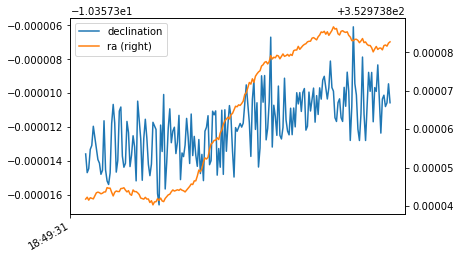

In [72]:
print(ra_dec.ra.value, ra_dec.dec.value)
dec['declination'].plot(legend=True)
ra['ra'].plot(legend=True, secondary_y=True)
#plt.savefig("/home/craiglagegit/DATA/RA_Dec_Trends_Take2_11Feb21.pdf")

In [73]:
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals - ra_dec.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec.dec.value)**2)) * 3600.0 
#ra_accuracies.append(ra_rms)
#dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")


RA rms = 0.18249395347554015. Dec rms = 0.11860769884378303.


In [70]:
(ra_dec.ra.value - 352.973816304431) * 3600.0

-0.00034257509469171055

In [ ]:
# Slew to starting position and take an image to check headers
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take a quick image to get some header data
await latiss.take_engtest(exptime=1)


In [ ]:
# Check tracking
end_time = Time(Time.now(), format='fits', scale='tai')
t_end = end_time + TimeDelta(5, format='sec')
nsec = 5
await asyncio.sleep(6)
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]

In [ ]:
dec['declination'].plot(legend=True)
ra['ra'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/RA_Dec_Trends_Take2_11Feb21.pdf")

In [ ]:
az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1)
el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1)

In [ ]:
az['azimuthCalculatedAngle'].plot(legend=True)
el['elevationCalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/Az_El_Trends_11Feb21.pdf")

In [ ]:
len(dec_vals)

In [ ]:
dec_time_vals = np.array(dec.values.tolist())[:,1]
ra_time_vals = np.array(ra.values.tolist())[:,1]

In [ ]:
plt.plot(dec_time_vals, dec_vals)

In [ ]:
plt.plot(ra_time_vals[98:103], ra_vals[98:103], marker='x')

In [ ]:
ra_vals[98:103]

In [ ]:
new_dec_vals = np.zeros([500])
new_ra_vals = np.zeros([500])
for i in range(5):
    for j in range(100):
        index = i * 100 + j
        new_index = i * 100 + (99 - j)
        if i % 2 == 0:
            new_dec_vals[index] = dec_vals[new_index]
            new_ra_vals[index] = ra_vals[new_index]
        else:
            new_dec_vals[index] = dec_vals[index]
            new_ra_vals[index] = ra_vals[index]

    

In [ ]:
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.7)
plt.title("Dec Values")
plt.plot(dec_time_vals, dec_vals)
plt.subplot(2,1,2)
plt.title("Dec Values with order of even seconds reversed")
plt.plot(dec_time_vals, new_dec_vals)
plt.savefig("/home/craiglagegit/DATA/Dec_Reversal_11Feb21.pdf")

In [ ]:
plt.plot(dec_time_vals, new_ra_vals)

In [ ]:
t1 = Time('2021-02-11T15:58:18.533', scale='tai')
t2 = t1 + TimeDelta(1, format='sec', scale='tai')
df = await client.select_time_series('lsst.sal.ATPtg.mount_positions', '*', t1, t2)


In [ ]:
print(df['ra99'],df['ra0'])

In [ ]:
# This is where the tests are carried out.
times = []
ra_accuracies = []
dec_accuracies = []

# Slew to starting position
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take a quick image to get some header data
await latiss.take_engtest(exptime=1)

# Now slew to new target
print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec_target.ra), dec=str(ra_dec_target.dec),
                      rot=d_rot, slew_timeout=240., 
                      stop_before_slew=False, wait_settle=False)
end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=1)

t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals*15.0 - ra_dec_target.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec_target.dec.value)**2)) * 3600.0 
ra_accuracies.append(ra_rms)
dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")

# Repeat this going back to origin

print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)

end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=1)

t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals*15.0 - ra_dec.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec.dec.value)**2)) * 3600.0 
ra_accuracies.append(ra_rms)
dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")



In [ ]:
# Now check to see if the specs are met:
Aux_Tel_Smslew_AcqTime = 10.0
if max(times) < Aux_Tel_Smslew_AcqTime:
    print(f"Aux_Tel_Smslew_AcqTime passed.  Spec = {Aux_Tel_Smslew_AcqTime}.\
    Measured = {max(times)} ")
else:
    print(f"Aux_Tel_Smslew_AcqTime failed!  Spec = {Aux_Tel_Smslew_AcqTime}.\
    Measured = {max(times)} ")

Aux_Tel_Sm_Slew_Abs_Pointing = 2.5
worst_case = max(ra_accuracies + dec_accuracies)
if worst_case < Aux_Tel_Sm_Slew_Abs_Pointing:
    print(f"Aux_Tel_Sm_Slew_Abs_Pointing passed.  Spec = {Aux_Tel_Sm_Slew_Abs_Pointing}. \
    Measured = {worst_case} ")
else:
    print(f"Aux_Tel_Sm_Slew_Abs_Pointing failed!  Spec = {Aux_Tel_Sm_Slew_Abs_Pointing}. \
    Measured = {worst_case} ")


In [ ]:
#await salobj.set_summary_state(atcs.rem.atptg, salobj.State.STANDBY)

In [ ]:
#await salobj.set_summary_state(atcs.rem.atmcs, salobj.State.STANDBY)

In [ ]:
# For shutdown of system
await atcs.stop_tracking()

In [ ]:
# turn off corrections
tmp = await atcs.rem.ataos.cmd_disableCorrection.set_start(m1=True, hexapod=True, atspectrograph=True)

In [ ]:
# Putting everything back in standby.
await atcs.shutdown()

In [ ]:
# take event checking out the slew commands to test telescope only
# otherwise it'll wait for the dome before completing slew command
atcs.check.atdome = False
atcs.check.atdometrajectory = False

In [ ]:
await atcs.rem.atdome.cmd_start.set_start(settingsToApply="test", timeout=30)

In [ ]:
await salobj.set_summary_state(atcs.rem.atdome, salobj.State.STANDBY, settingsToApply="test")

In [ ]:
await salobj.set_summary_state(atcs.rem.atdometrajectory, salobj.State.STANDBY)

In [ ]:
await salobj.set_summary_state(latiss.rem.atspectrograph, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atcamera, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atheaderservice, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atarchiver, salobj.State.STANDBY)